<a href="https://colab.research.google.com/github/Seojun-AK/img_seg_training/blob/main/Image_Segmentation_Unet_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 이미지 분할

이 튜토리얼은 수정된 <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a>을 이용하여 이미지 분할에 집중합니다.

## 이미지 분할이란?

지금까지 네트워크의 과제가 입력 이미지에 레이블이나 클래스를 할당하는 이미지 분류를 보았습니다. 그러나 이미지에서 개체가 있는 위치, 해당 개체의 모양, 어떤 픽셀이 어떤 객체에 속하는지 등을 알고 싶다고 가정해 보세요. 이 경우 이미지를 분할하고 싶을 것입니다. 즉, 이미지의 각 픽셀에 레이블이 부여됩니다. 따라서 영상 분할의 과제는 영상의 픽셀 단위의 마스크를 출력하도록 신경망를 훈련시키는 것입니다.이것은 훨씬 낮은 레벨, 즉 픽셀 레벨에서 이미지를 이해하는 데 도움이 됩니다. 이미지 분할은 의료 영상, 자율주행차, 위성 영상화 분야에서 많이 응용이 되고 있습니다.

이번 튜토리얼에 사용 될 데이터 세트는  Parkhi *et al*이 만든 [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)입니다. 데이터 세트는 영상, 해당 레이블과 픽셀 단위의 마스크로 구성됩니다. 마스크는 기본적으로 각 픽셀의 레이블입니다. 각 픽셀은 다음 세 가지 범주 중 하나가 주어집니다:

*   class 1 : 애완동물이 속한 픽셀
*   class 2 : 애완동물과 인접한 픽셀
*   class 3 : 위에 속하지 않는 경우/주변 픽셀

In [2]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-6wfa1pq4
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-6wfa1pq4
  Created wheel for tensorflow-examples: filename=tensorflow_examples-88287d08f9fe73ef20bbea3cc004440b1c7299f9_-py3-none-any.whl size=299303 sha256=921e588018806184cbbd695412face472a509f2e0dc2383e92cd0cae65ba7384
  Stored in directory: /tmp/pip-ephem-wheel-cache-tvd8n4_e/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/i

## 필요 모듈 import


In [3]:
import tensorflow as tf

In [4]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Oxford-IIIT Pets 데이터 세트를 다운로드 하기

데이터 세트는 이미 텐서플로 데이터 세트에 포함되어 있으며, 다운로드만 하면 됩니다. 분할 마스크는 버전 3+에 포함되어 있습니다. 

In [5]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True) # tensorflow datasets에서 oxford_iiit 데이터 다운

Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


다음 코드는 이미지를 뒤집는 간단한 확장을 수행합니다. 또한, 영상이 [0,1]로 정규화됩니다. 마지막으로, 위에서 언급한 것처럼 분할 마스크의 픽셀에 {1, 2, 3}이라는 레이블이 붙습니다. 편의성을 위해 분할 마스크에서 1을 빼서 레이블이 {0, 1, 2}이 되도록 합시다.

In [6]:
def normalize(input_image, input_mask): # 정규화 작업
  input_image = tf.cast(input_image, tf.float32) / 255.0 # tf.cast(data, type) -> data를 type로 형변환
  input_mask -= 1 # mask label값에서 -1 할당
  return input_image, input_mask

In [7]:
@tf.function # 데코레이터로 tf.function 선언
def load_image_train(datapoint): # 이미지 불러오는 함수 선언, train data
  input_image = tf.image.resize(datapoint['image'], (128, 128)) # input_image resize 
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128)) # segmentation을 할 mask도 같은 사이즈로 resize

  if tf.random.uniform(()) > 0.5: # random하게 
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [8]:
def load_image_test(datapoint): # test data, train과 동일일
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask) # normalize 진행행

  return input_image, input_mask

In [18]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/tmp/tmp60jfzv24tfds',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
     

In [14]:
info.splits['train']

<SplitInfo num_examples=3680, num_shards=4>

데이터 세트에는 이미 필요한 몫의 시험과 훈련이 포함되어 있으므로 동일한 분할을 계속 사용합시다.

In [9]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [10]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [11]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

이미지 예제와 데이터 세트에서 대응하는 마스크를 보도록 합시다. 

In [12]:
def display(display_list): # 출력 메소드 작성
  plt.figure(figsize=(15, 15)) # 크기

  title = ['Input Image', 'True Mask', 'Predicted Mask'] # 타이틀 설정

  for i in range(len(display_list)): # list형 데이터를 받아서 출력
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i])) # array 값을 img로 변환하여 출력
    plt.axis('off')
  plt.show()

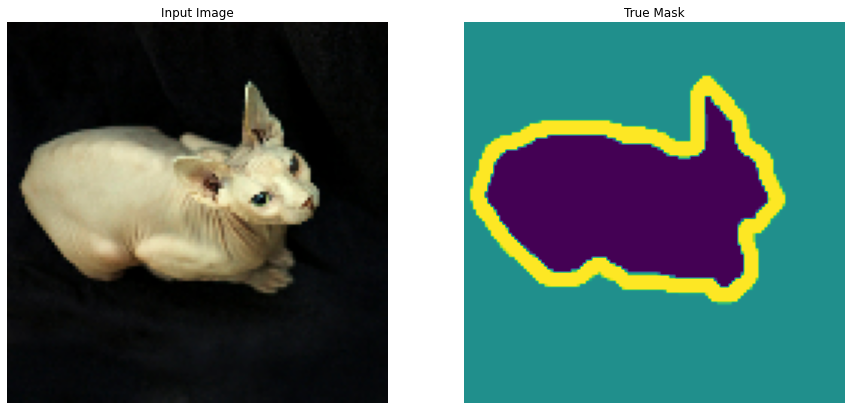

In [13]:
for image, mask in train.take(1): # 1번 데이터만 sample로 출력력
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## 모델 정의하기
여기서 사용하는 모델은 수정된 U-Net입니다. U-Net은 인코더(다운샘플러)와 디코더(업샘플러)를 포함합니다. 강력한 기능을 학습하고 훈련 가능한 매개변수의 수를 줄이기 위해 미리 훈련된 모델을 인코더로 사용할 수 있습니다. 따라서 이번 과제의 인코더는 미리 훈련된 MobileNetV2 모델이 될 것이며 이 모델의 중간 출력이 사용될 것입니다. 디코더는 [Pix2pix 튜토리얼](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py)의 TensorFlow 예제에서 이미 구현된 업샘플 블록이 될 것입니다. 

3개의 채널을 출력하는 이유는 픽셀당 3개의 가능한 라벨이 있기 때문입니다. 이것을 각 화소가 세 개의 class로 분류되는 다중 분류라고 생각하세요. 

In [14]:
OUTPUT_CHANNELS = 3

언급된 바와 같이 인코더는 미리 훈련된 MobileNetV2 모델이 될 것이며, [tf.keras.applications](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications)에서 사용될 준비가 될 것입니다. 인코더는 모델의 중간 층에서 나오는 특정 출력으로 구성됩니다. 인코더는 교육 과정 중에 학습되지 않는다는 점에 유의하세요.

In [15]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False) # base 모델 설정

#이 층들의 활성화를 이용합시다
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# 특징추출 모델을 만듭시다
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers) # 미리 학습된 가중치 down

down_stack.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


디코더/업샘플러는 TensorFlow 예제에서 구현된 일련의 업샘플 블록입니다.

In [16]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [17]:
def unet_model(output_channels): # U-net model 생성
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # 모델을 통해 다운샘플링합시다
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # skip-connection 설정 (건너뛰기 연결을 업샘플링하고 설정하세요)
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # 이 모델의 마지막 층입니다
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## 모델 훈련하기
이제 모델을 컴파일하고 훈련시키는 일만 남았습니다. 여기서 사용되고 있는 손실 함수는 loss.sparse_categorical_crossentropy입니다. 이 손실 함수를 사용하는 이유는 네트워크가 멀티 클래스 예측과 마찬가지로 픽셀마다 레이블을 할당하려고 하기 때문입니다. 실제 분할 마스크에서 각 픽셀은 {0,1,2}를 가지고 있습니다. 이곳의 네트워크는 세 개의 채널을 출력하고 있습니다. 기본적으로 각 채널은 클래스를 예측하는 방법을 배우려고 하고 있으며, loss.sparse_categical_crossentropy는 그러한 시나리오에 권장되는 손실입니다. 네트워크의 출력을 사용하여 픽셀에 할당된 레이블은 가장 높은 값을 가진 채널입니다.이것이 create_mask 함수가 하는 일입니다.

In [18]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', # adam optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # sparse_categorical_crossentropy : 다중분류 손실함수. integer type class. one-hot encoding 과정X
              metrics=['accuracy'])

만들어진 모델의 구조를 간략히 살펴 보겠습니다.

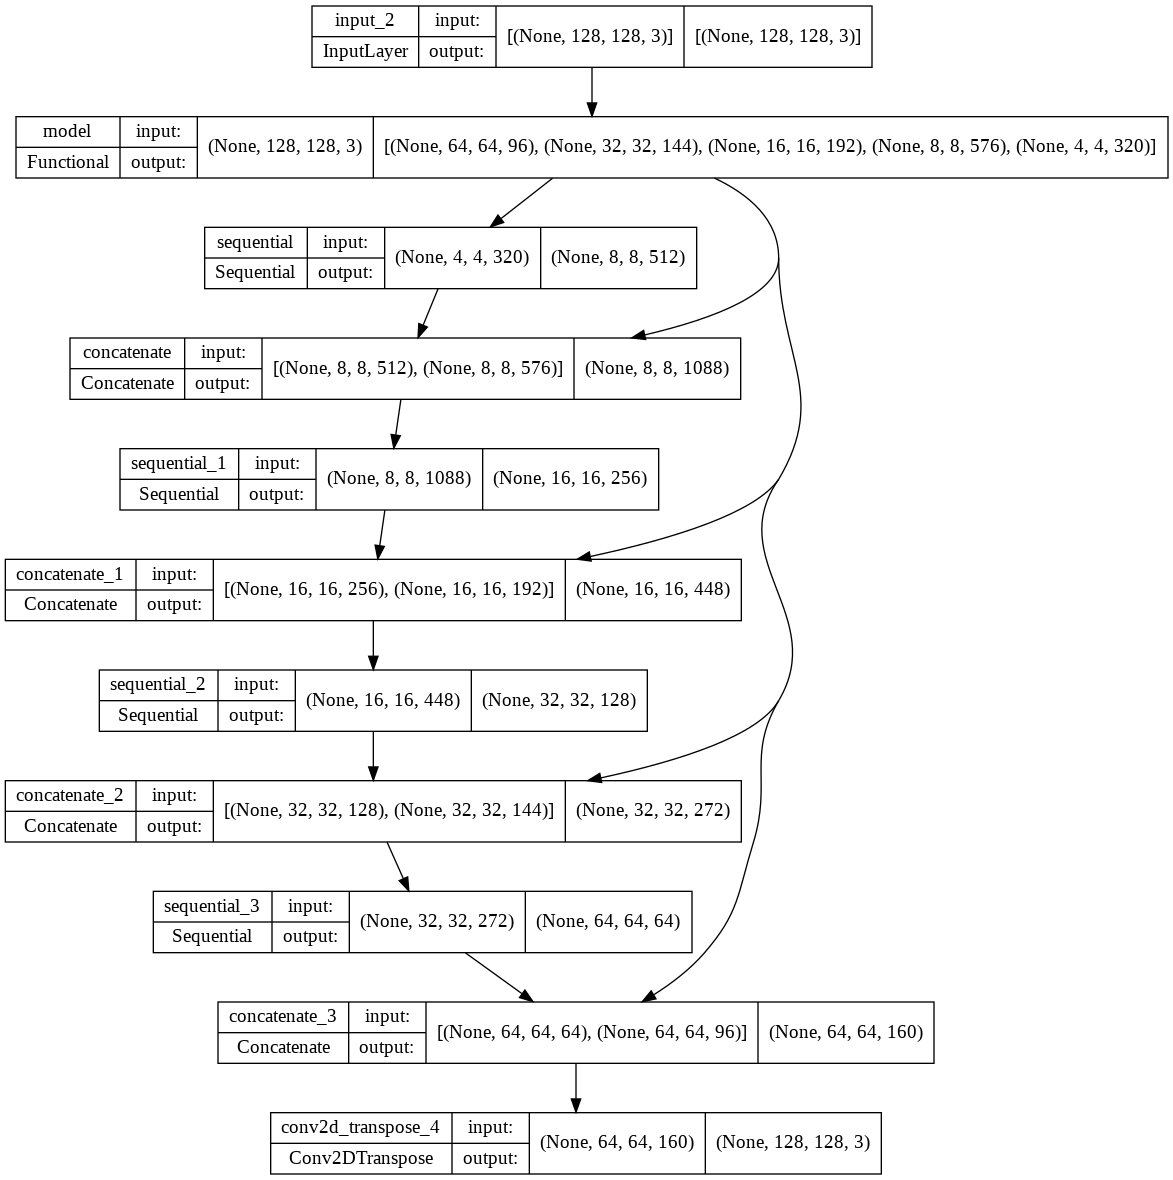

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True)

모델을 시험해보고 훈련 전에 예측한 것이 무엇인지 알아봅시다. 

In [20]:
def create_mask(pred_mask): # 예측 마스크 생성성
  pred_mask = tf.argmax(pred_mask, axis=-1) # argmax값을 추출
  pred_mask = pred_mask[..., tf.newaxis] # 새로운 축 생성성
  return pred_mask[0]

In [21]:
def show_predictions(dataset=None, num=1): # 예측값 출력력
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

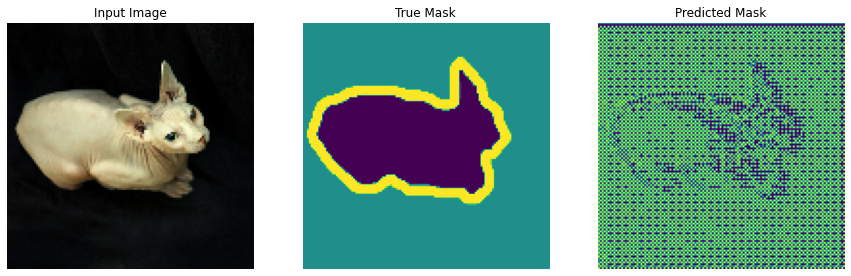

In [22]:
show_predictions()

모델이 훈련하는 동안 어떻게 향상되는지 관찰해 봅시다. 이 작업을 수행하기 위해 콜백 함수가 아래에 정의되어 있습니다.

In [23]:
class DisplayCallback(tf.keras.callbacks.Callback): # Callback : 모델을 학습증 호출할 수 있는 기능
  def on_epoch_end(self, epoch, logs=None): # epoch이 끝날 때때
    clear_output(wait=True)
    show_predictions()
    print ('\n에포크 이후 예측 예시 {}\n'.format(epoch+1))

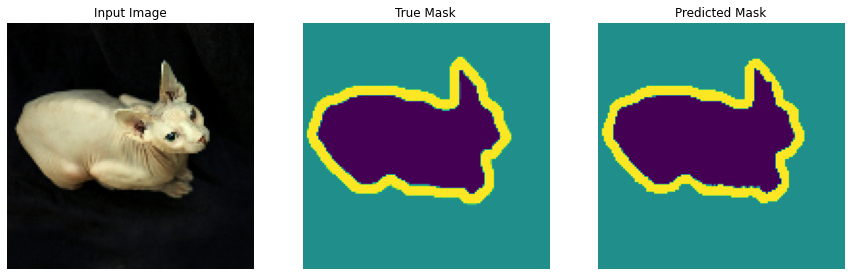


에포크 이후 예측 예시 50

57/57 [==============================] - 9s 157ms/step - loss: 0.0365 - accuracy: 0.9745 - val_loss: 0.7898 - val_accuracy: 0.8847


In [30]:
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

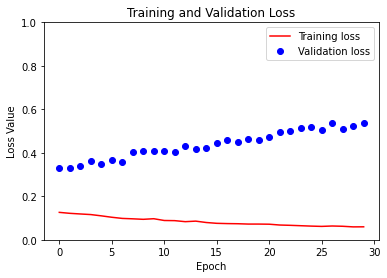

In [28]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS) 

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## 예측하기

몇 가지 예측을 해봅시다. 시간을 절약하기 위해 에포크 수를 작게 유지했지만, 보다 정확한 결과를 얻기 위해 에포크를 더 높게 설정할 수 있습니다.

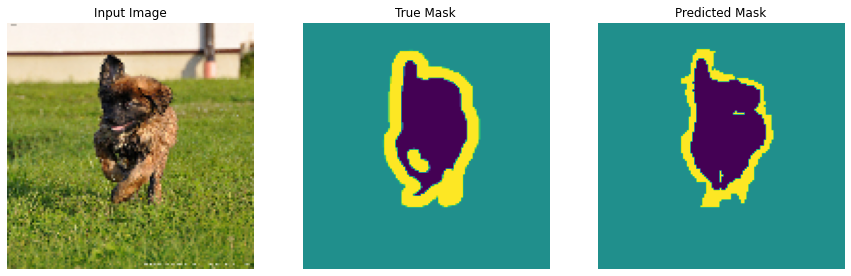

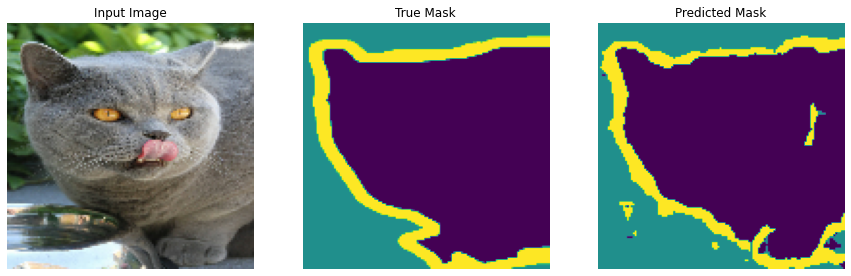

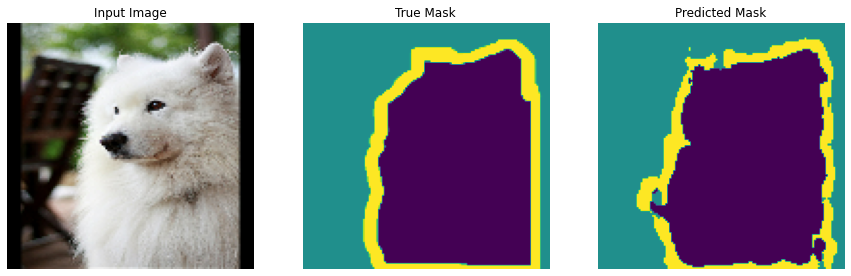

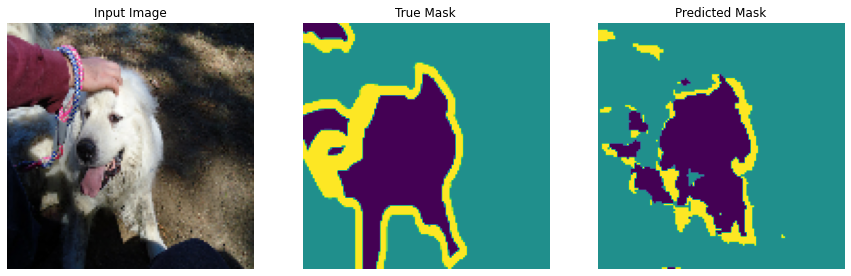

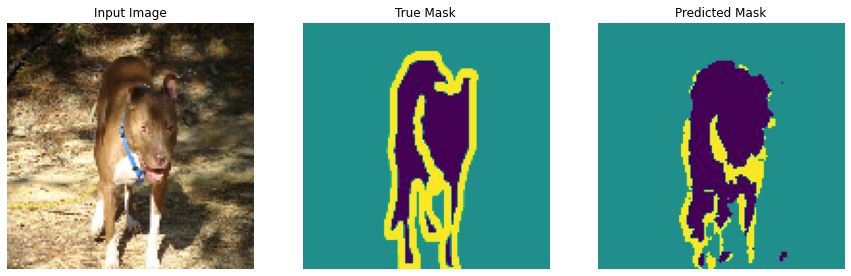

In [29]:
show_predictions(test_dataset, 5)

## 다음 단계
이제 이미지 분할이 무엇이고 어떻게 작동하는지 이해했으니, 이 튜토리얼을 다른 중간 계층 출력 또는 미리 조정한 다른 모델에도 사용해 보세요. 여러분은 또한 카글에서 주최하는 [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge/overview) 이미지 마스킹 챌린지을 시도함으로써 본인의 실력을 시험해볼 수 있습니다. 
 자신의 데이터를 재훈련할 수 있는 다른 모델의 [Tensorflow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection)를 참조하세요.